In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from nansat import Nansat, Domain, NSR

from sea_ice_drift.lib import get_spatial_mean, get_uint8_image
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching



%matplotlib inline

In [4]:
from osgeo import gdal

In [5]:
# Download arrays
#!wget https://github.com/nansencenter/sea_ice_drift_test_files/raw/master/S1B_EW_GRDM_1SDH_20200123T120618.npy
#!wget https://github.com/nansencenter/sea_ice_drift_test_files/raw/master/S1B_EW_GRDM_1SDH_20200125T114955.npy
f1 = gdal.Open("/home/jovyan/work/icedrift/Special_curriculum/19-20_subset_experiment/SAR/subset_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV_Cnv.tif")
f2 = gdal.Open("/home/jovyan/work/icedrift/Special_curriculum/19-20_subset_experiment/SAR/subset_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV_Cnv.tif")

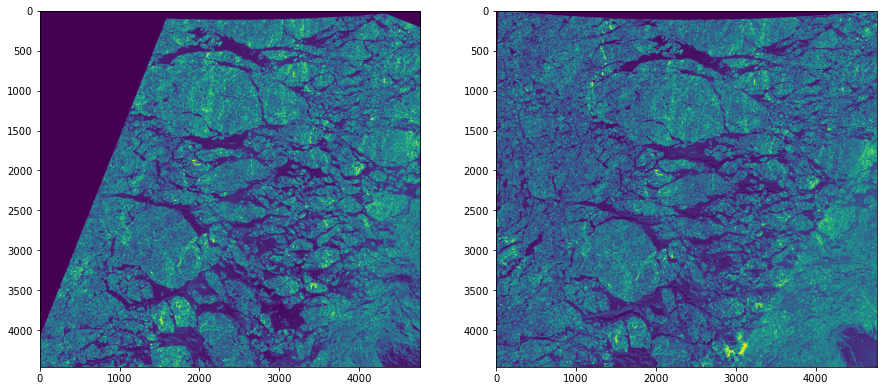

In [6]:
# load example ar2rays
a1 = f1.ReadAsArray()
a2 = f2.ReadAsArray()
#a1 = a1[~np.any(np.isnan(a1), axis=1), :]
#a2 = a2[~np.any(np.isnan(a2), axis=1), :]

fig, ax = plt.subplots(1,2, figsize=(15,10))
im0 = ax[0].imshow(a1)
#plt.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(a2)
#plt.colorbar(im1, ax=ax[1])
plt.show()

In [7]:
# Close the dataset
f1 = None
f2 = None

In [8]:
# Create two Nansat objects with fake georeference (Mercator projection).
# The same georefercne will be use for retrieval of drift.
# True knowledge about georeference of input arrays is prefered.

srs = NSR(3396)
rows, cols = a1.shape
pixel_size = 100 # meters
d = Domain(srs.wkt, f'-te 0 0 {cols*pixel_size} {rows*pixel_size} -ts {cols} {rows}')
n1 = Nansat.from_domain(d, a1)
n2 = Nansat.from_domain(d, a2)

In [9]:
# Run Feature Tracking
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=20000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 20000
Key points found: 20000
Domain filter: 20000 -> 20000
Domain filter: 20000 -> 20000
Keypoints matched 1.098649263381958
Ratio test 0.600000 found 352 keypoints
MaxDrift filter: 352 -> 352
LSTSQ filter: 352 -> 352


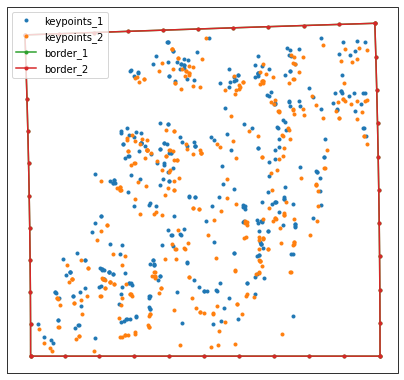

In [10]:
# Plot identified and matched keypoints in geographic coordinates

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.Mercator())
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

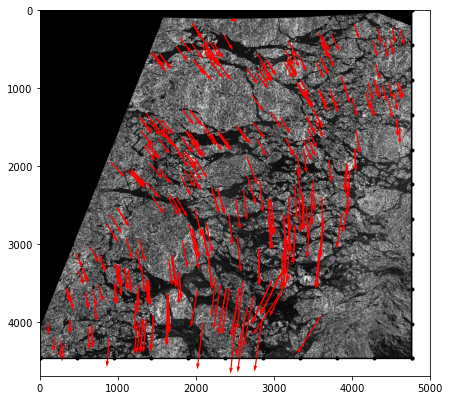

In [11]:
# Plot ice drift on top of image_1

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(7,7))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.5)
plt.plot(n1lon2b, n1lat2b, 'k.-')
plt.show()

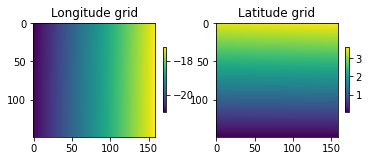

In [12]:
# Create lon/lat grids 

# lon/lat grids in polar stereographic projection covering image_1
pm_step = 30 # lon/lat grids are subsampled
lon1pm, lat1pm = d.get_geolocation_grids(pm_step)
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()

In [13]:
# Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Mercator (faked) projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4())

100% 00300.0 04260.0 00287.0 04366.0 -03.0 0.80 12.674% 03000.0 00210.0 02981.0 00278.0 +03.0 0.37 4.6013% 01200.0 00570.0 0000nan 0000nan +0nan 0nan 0nan10% 01800.0 00450.0 01873.0 00547.0 -03.0 0.79 9.8015% 02250.0 00660.0 02321.0 00760.0 +03.0 0.68 7.4428% 00540.0 01230.0 0000nan 0000nan +0nan 0nan 0nan37% 03060.0 01560.0 03117.0 01671.0 -03.0 0.65 15.4138% 04380.0 01590.0 04353.0 01678.0 +03.0 0.32 3.4648% 01560.0 02010.0 01635.0 02108.0 +00.0 0.80 13.76
 Pattern matching - OK! ( 17 sec)


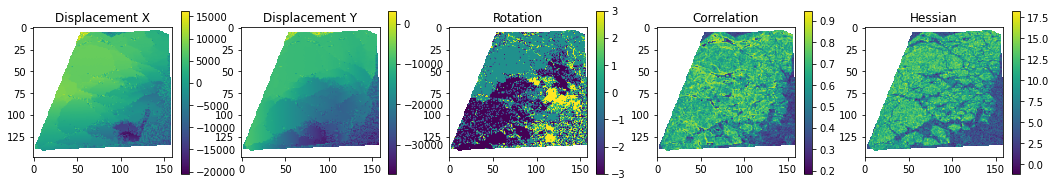

In [14]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i])

plt.show()

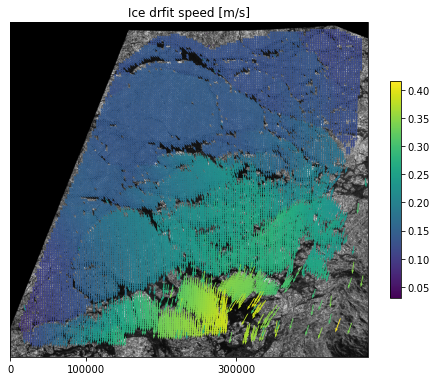

In [34]:
# compute ice drift speed [m/s]
delta_t = 88851 #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt(v**2+u**2) 

# plot valid vectors in Polar stereographic projection
gpi = (hpm > 7) 
# X/Y grids in polar stereographic projection covering image_1
x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)

# spacial reference for plotting
crs = ccrs.Mercator()

plt.figure(figsize=(8,8))
ax = plt.axes(projection=crs)

'''
ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv=ax.quiver(x1pm[gpi], y1pm[gpi], upm[gpi], vpm[gpi], rpm[gpi], scale=100000, cmap='jet', width=0.008)
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

'''

ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv=ax.quiver(x1pm[gpi], y1pm[gpi], u[gpi], v[gpi],speed[gpi], scale=10)
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])


ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.show()

In [113]:
#EXPORTING DATA TO 'DEFORMATION' NOTEBOOK, GETTING BACK RESULTS AND VISUALIZING DEFORMATION
%store upm
%store vpm
%store rpm
%store hpm
%store f1
%store f2
%store delta_t

Stored 'upm' (ndarray)
Stored 'vpm' (ndarray)
Stored 'rpm' (ndarray)
Stored 'hpm' (ndarray)
Stored 'f1' (NoneType)
Stored 'f2' (NoneType)
Stored 'delta_t' (int)


In [26]:
#Import data from deformation results
%store -r divergence_sr
%store -r convergence_sr
%store -r shear_sr
%store -r total_sr

%store -r divergence_dr
%store -r convergence_dr
%store -r shear_dr
%store -r total_dr

%store -r e_div_dr

%store -r divergence_n2
%store -r convergence_n2
%store -r shear_n2
%store -r total_n2

%store -r e_tot

In [37]:
mskt = (total_dr>7)
# filter mask
msk_total_dr  = mskt*1

# filter data arrays    
total_dr_msk = total_dr*mskt

# set no data to nan
total_dr_msk[mskt==0.0] = np.nan

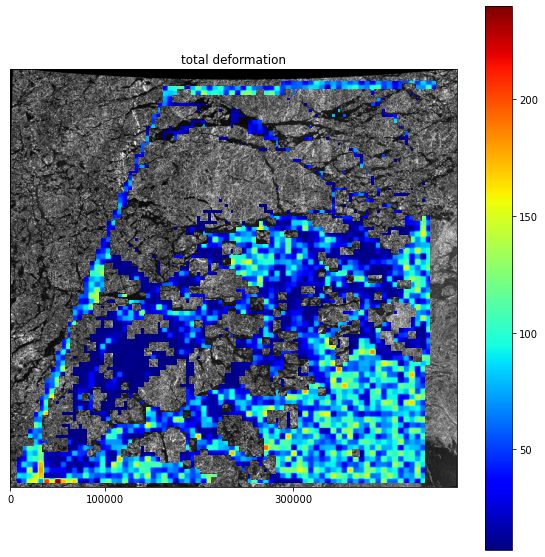

In [38]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

#(axes)  = plt.subplots(2,2, figsize=(30,30), sharex='all', sharey='all')
ax.imshow(a2, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
im=ax.imshow(total_dr_msk, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper', cmap = 'jet') # for transparency  alpha = 0.3
plt.title('total deformation')
#divider = make_axes_locatable(axes[0][0])
#cax = divider.append_axes("right", size="5%", pad=0.05)
#clb1 = plt.colorbar(pm1, cax=cax)
#clb1.ax.set_xlabel(clb_txt)
#clb1.ax.tick_params(labelsize=FS-5)

ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])
ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
#plt.axes('off')
plt.colorbar(im)

    
    
plt.show()

